# CESM2-LE analysis  of snow melt and runoff
## Observed SWE regridding
### Readings in:
- Mudryk et al SWE reconstruction from Mudryk, et al (2020). Historical Northern Hemisphere snow cover trends and projected changes in the CMIP6 multi-model ensemble. Cryosphere, 14(7), 2495-2514. doi: 10.5194/tc-14-2495-2020.

- Univ of AZ SWE reconstruction from Broxton, P., X. Zeng, and N. Dawson. 2019. Daily 4 km Gridded SWE and Snow Depth from Assimilated In-Situ and Modeled Data over the Conterminous US, Version 1. Boulder, Colorado USA. NASA National Snow and Ice Data Center Distributed Active Archive Center. doi: https://doi.org/10.5067/0GGPB220EX6A. [accessed Jan 4, 2022].
  - see also Zeng, X., P. Broxton, and N. Dawson. 2018. Snowpack Change From 1982 to 2016 Over Conterminous United States, Geophysical Research Letters. 45. 12940-12947. https://doi.org/10.1029/2018GL079621
 
- Other data available through ILAMB

Will Wieder wwieder@ucar.edu 

In [1]:
%load_ext autoreload
%autoreload 2
import glob
import os

import cftime
import dask
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import cartopy.crs as ccrs

import numpy as np
import pandas as pd
import xarray as xr
from scipy import signal,stats
from scipy.stats import spearmanr

from distributed import wait
from sklearn.linear_model import LinearRegression

%matplotlib inline

### Fetch cluster

In [2]:
# Updated for PBS scheduler
# this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        project='P93300641', # Input your project ID here
        walltime='2:30:00', # Amount of wall time
        interface='ib0', # Interface to use
    )

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })

    client = Client(cluster)
    return cluster, client

In [3]:
cluster, client = get_ClusterClient(nmem='25GB')
cluster.scale(10) 

In [4]:
cluster

------
### Read in march data from Mudryk [from ILAMB] & GlobSnow_v3.0
- GlobSnow_v3.0 won't open for some reason

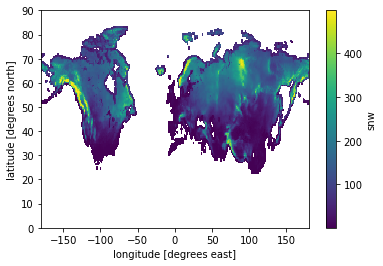

In [5]:
pathIN = '/glade/p/cgd/tss/people/wwieder/SNOW_OBS/'
fileIN =  pathIN + 'SWE_obsMEANrn_C05_1981_2014_0r500.nc'

MudSnow = xr.open_dataset(fileIN).persist()

_ = wait(MudSnow)
MudSnow = MudSnow.where(MudSnow<1e36)
MudSnow.snw.max('time').plot() ; 

#fileIN =  pathIN + 'GlobSnow_v3.0_monthly_biascorrected_SWE/199703_*_biascorrected_swe_0.25grid.nc'
#GlobSnow = xr.open_dataset(fileIN)#, preprocess=None,

#GlobSnow = xr.open_mfdataset(fileIN)#, preprocess=None,
#                       combine='by_coords',parallel=True,
#                      concat_dim=['time']).persist()
#_ = wait(GlobSnow)
#GlobSnow

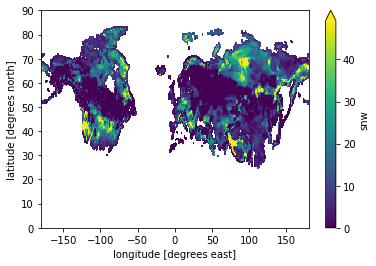

In [6]:
# subset observations to get March data only?
# Seems like some regions have peak swe outside of March
(MudSnow.snw.max('time')-MudSnow.where(MudSnow.time['time.month'] == 3).snw.max('time')).plot(robust=True) ; 

In [7]:
minLat, maxLat = MudSnow.lat.min(), MudSnow.lat.max()
#minLon, maxLon = MudSnow.lon.min(), MudSnow.lon.max()

#### Read in CESM results, 
- here from single ensemble member, just to get target grid  

/glade/campaign/cgd/cesm/CESM2-LE/timeseries/lnd/proc/tseries/month_1/H2OSNO/b.e21.BHISTcmip6.f09_g17.LE2-1301.009.clm2.h0.H2OSNO.199001-199912.nc


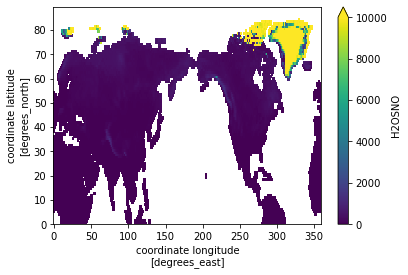

In [8]:
CESM_in = '/glade/campaign/cgd/cesm/CESM2-LE/timeseries/'+ \
            'lnd/proc/tseries/month_1/H2OSNO/'
CESM_in = CESM_in + 'b.e21.BHISTcmip6.f09_g17.LE2-1301.009.clm2.h0.H2OSNO.199001-199912.nc'

print(CESM_in)
dsCESM = xr.open_mfdataset(CESM_in)

#Mask to CONUS
dsCESM = dsCESM.sel(lat=slice(minLat,maxLat))
dsCESM.H2OSNO.max('time').plot(robust=True) ;    

In [9]:
#### Regrid results
import xesmf as xe  # to regrid observations

MudSnow_out = xr.Dataset({'lat': (['lat'], dsCESM.lat),
                     'lon': (['lon'], dsCESM.lon)})

# NOTE: [from xesmf], Data arrays should have (lat, lon) on the right. 
# If not, use DataArray.transpose or numpy.transpose to preprocess the data.
# Note this is also a pretty quick and dirty job, not sure how coastlines are bing handled?

Regridder = xe.Regridder(MudSnow, MudSnow_out, 'bilinear',periodic=True, reuse_weights=False)

In [10]:
MudSnow_out = Regridder(MudSnow)
MudSnow_out['snw'].attrs = MudSnow.snw.attrs

# Write out data product
outDir = '/glade/scratch/wwieder/VernalWindow/'
MudSnow_out.to_netcdf(outDir+'Mudryk_SWE.nc')
print('wrote out to '+outDir)

/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/xesmf/frontend.py:508: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


wrote out to /glade/scratch/wwieder/VernalWindow/


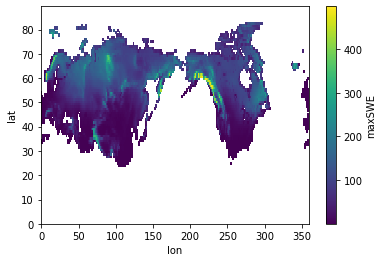

In [11]:
MudSnow_out['maxSWE'] = MudSnow_out['snw'].groupby('time.year').max('time')
MudSnow_out =  MudSnow_out['maxSWE']
MudSnow_out= MudSnow_out.rename({'year': 'time'})
MudSnow_out.mean('time').plot() ;

#### Mask out observations as with CESM2-LE

In [12]:
LE_in = '/glade/scratch/wwieder/VernalWindow/SnowStatsSWE_ens*.nc'
LE_ds = xr.open_mfdataset(LE_in,combine='nested',parallel=True,
                                    concat_dim=['ens']).persist()
# mask out to CONUS
LE_ds = LE_ds.sel(lat=slice(minLat,maxLat))
minY, maxY = MudSnow_out.time.min(), MudSnow_out.time.max()


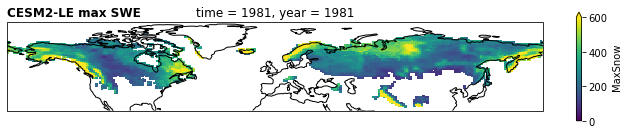

In [13]:
#subset over observational period (1981-2014)
import cartopy.feature as cfeature
temp = LE_ds.MaxSnow.sel(time=slice(minY,maxY)).max(['ens'])

fig = plt.figure(figsize=[12,2])
ax = plt.axes(projection=ccrs.PlateCarree())
temp.isel(time=0).plot.pcolormesh(ax=ax, vmin=0, vmax=600);
ax.coastlines();
ax.set_title('CESM2-LE max SWE', loc='left', fontsize='large', fontweight='bold') ;

# Clip observations to same spatial domain
minLat, maxLat = LE_ds.lat.min(), LE_ds.lat.max()
MudSnow_out = MudSnow_out.sel(lat=slice(minLat,maxLat))

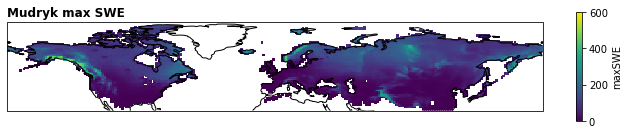

In [14]:
fig = plt.figure(figsize=[12,2])
obs = MudSnow_out
#obs = obs.where(obs.max('time') > 10)
ax = plt.axes(projection=ccrs.PlateCarree())
obs.mean('time').plot.pcolormesh(ax=ax, vmin=0, vmax=600);
ax.coastlines();
ax.set_title('Mudryk max SWE', loc='left', fontsize='large', fontweight='bold') ;

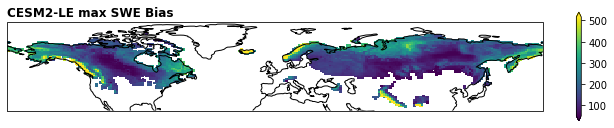

In [15]:
plt.figure(figsize=[12,2])
error = temp.mean('time') - obs.mean('time')
ax = plt.axes(projection=ccrs.PlateCarree())
error.plot(robust=True);
ax.coastlines();
ax.set_title('CESM2-LE max SWE Bias', loc='left', fontsize='large', fontweight='bold') ;


---
#### Look at trends in CESM2-LE and Mudryk data

In [16]:
# colorbrewer colormap, diverging, brown->blue
ccc = np.zeros([15,3]);
ccc[14,:] = 39, 129, 240
ccc[13,:] = 59, 150, 244
ccc[12,:] = 80, 165, 244
ccc[11,:] = 124, 184, 249
ccc[10,:] = 150, 210, 249
ccc[9,:] = 179, 240, 249
ccc[8,:] = 224, 255, 255 
ccc[7,:] = 255, 255, 255
ccc[6,:] = 249, 240, 239
ccc[5,:] = 240, 220, 210
ccc[4,:] = 224, 190, 179
ccc[3,:] = 199, 159, 150
ccc[2,:] = 179, 140, 129
ccc[1,:] = 159, 120, 109
ccc[0,:] = 140, 100, 89
ccc = matplotlib.colors.ListedColormap(ccc/256)

ddd = np.zeros([13,3]); 
ddd[0,:] = 182, 106,  40
ddd[1,:] = 205, 133,  63
ddd[2,:] = 225, 165, 100
ddd[3,:] = 245, 205, 132
ddd[4,:] = 245, 224, 158
ddd[5,:] = 255, 245, 186
ddd[6,:] = 255, 255, 255
ddd[7,:] = 205, 255, 205
ddd[8,:] = 153, 240, 178
ddd[9,:] =  83, 189, 159
ddd[10,:] = 110, 170, 200
ddd[11,:] =   5, 112, 176
ddd[12,:] =   2,  56,  88
ddd = matplotlib.colors.ListedColormap(ddd/256)

/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/xarray/core/nputils.py:241: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


<xarray.Dataset>
Dimensions:               (degree: 2, lat: 63, lon: 288)
Coordinates:
  * degree                (degree) int64 1 0
  * lat                   (lat) float64 25.92 26.86 27.8 ... 82.46 83.4 84.35
  * lon                   (lon) float64 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
Data variables:
    polyfit_coefficients  (degree, lat, lon) float64 nan nan nan ... nan nan nan

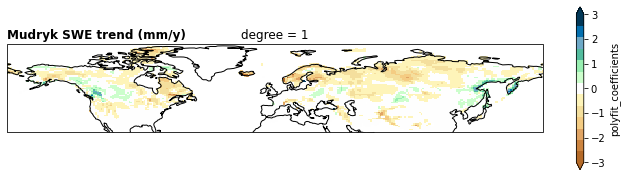

In [17]:
obs_trend = obs.polyfit('time',1)

plt.figure(figsize=[12,3])
ax = plt.axes(projection=ccrs.PlateCarree())
obs_trend.polyfit_coefficients.isel(degree=0).plot(cmap=ddd,vmax=3,vmin=-3) ;
ax.coastlines();
ax.set_title('Mudryk SWE trend (mm/y)', loc='left', fontsize='large', fontweight='bold') ;
obs_trend

<xarray.Dataset>
Dimensions:               (degree: 2, ens: 40, lat: 63, lon: 288)
Coordinates:
  * degree                (degree) int64 1 0
  * ens                   (ens) int64 10 11 12 13 14 15 16 ... 44 45 46 47 48 49
  * lat                   (lat) float64 25.92 26.86 27.8 ... 82.46 83.4 84.35
  * lon                   (lon) float64 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
Data variables:
    polyfit_coefficients  (degree, ens, lat, lon) float64 dask.array<chunksize=(2, 10, 63, 288), meta=np.ndarray>

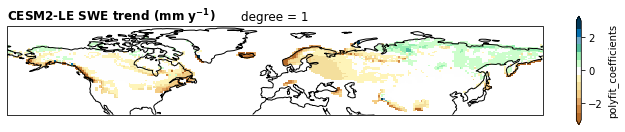

In [18]:
cesm_SWE = LE_ds.MaxSnow.sel(time=slice(minY,maxY))
cesm_trend = cesm_SWE.polyfit('time',1,full=False)
cesm_trend
plt.figure(figsize=[12,2])
ax = plt.axes(projection=ccrs.PlateCarree())
cesm_trend.mean('ens').polyfit_coefficients.isel(degree=0).plot(cmap=ddd,vmax=3,vmin=-3) ;
ax.coastlines();
ax.set_title('CESM2-LE SWE trend (mm $\mathregular{y^{-1}}$)', loc='left', fontsize='large', fontweight='bold') ;

cesm_trend

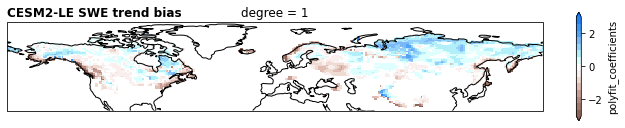

In [19]:
trend_bias = cesm_trend.mean('ens').polyfit_coefficients.isel(degree=0) - \
             obs_trend.polyfit_coefficients.isel(degree=0)

plt.figure(figsize=[12,2])
ax = plt.axes(projection=ccrs.PlateCarree())
trend_bias.plot(cmap=ccc,vmax=3,vmin=-3) ;
ax.coastlines();
ax.set_title('CESM2-LE SWE trend bias', loc='left', fontsize='large', fontweight='bold') ;

# mask out all but common grids
cesm_trend = cesm_trend.where(trend_bias>-100)
obs_trend = obs_trend.where(trend_bias>-100)

#### Add obs_trend to cesm_trend as ens 41

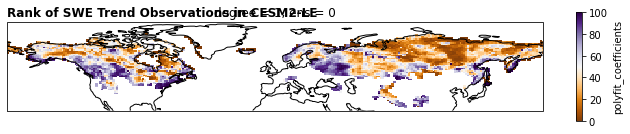

In [20]:
combined = xr.combine_nested([cesm_trend, obs_trend.expand_dims("ens")], 'ens')
ranked = combined.polyfit_coefficients.isel(degree=0).compute().rank('ens').isel(ens=40)
ranked = ranked / 41 * 100
ranked = ranked.where(ranked>(1/41), 0) #/41 * 100
ranked = ranked.where(ranked<100, 100) #/41 * 100
ranked = ranked.where(cesm_SWE.max(['time','ens'])>0)

plt.figure(figsize=[12,2])
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title('Rank of SWE Trend Observations in CESM2-LE', loc='left', fontsize='large', fontweight='bold') ;
ranked.plot(vmax=100,vmin=0,cmap='PuOr')
ax.coastlines();

In [21]:
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import copy
from matplotlib.colors import from_levels_and_colors

# Generate a function for making panel plots of maps
def map_function(da, cb=0, cmap='viridis', panel=None,  ax=None, 
                 title=None, vmax=None, vmin=None, units=None, norm=None):
    '''a function to make one subplot'''
    wrap_data, wrap_lon = add_cyclic_point(da.values, coord=da.lon)

    if ax is None: ax = plt.gca()

    cmap = copy.copy(plt.get_cmap(cmap))
    cmap.set_bad( "gray", alpha=0.05 )
    cmap.set_under( "white", alpha=1 )

    im = ax.pcolormesh(wrap_lon,da.lat,wrap_data,
                       transform=ccrs.PlateCarree(),
                       vmax=vmax,vmin=vmin,cmap=cmap,
                       norm=norm)

    ax.set_title(title,loc='left', fontsize='large', fontweight='bold')
    ax.coastlines()
    ax.set_extent([-180,180,25,85], crs=ccrs.PlateCarree())
    ax.annotate(panel, xy=(0.05, 0.90), xycoords=ax.transAxes,
                ha='center', va='center',fontsize=16)    
    ocean = ax.add_feature(
        cfeature.NaturalEarthFeature('physical','ocean','110m', facecolor='white'))
    # allows for different colorbars on each plot
    if cb == 1:
        cbar = fig.colorbar(im, ax=ax,pad=0.02, fraction = 0.05, orientation='horizontal')
        cbar.set_label(units,size=12,fontweight='bold')
    if cb == 2:
        cbar = fig.colorbar(im, ax=ax,pad=0.02, fraction = 0.05, orientation='vertical')    
        cbar.set_label(units,size=12)#,weight='bold')


/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:310: UserWarning: The colormap's 'bad' has been set, but in order to wrap pcolormesh across the map it must be fully transparent.
  return func(self, *args, **kwargs)


/glade/scratch/wwieder/VernalWindow/FigS2_global_SWE_TREND.pdf


/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.


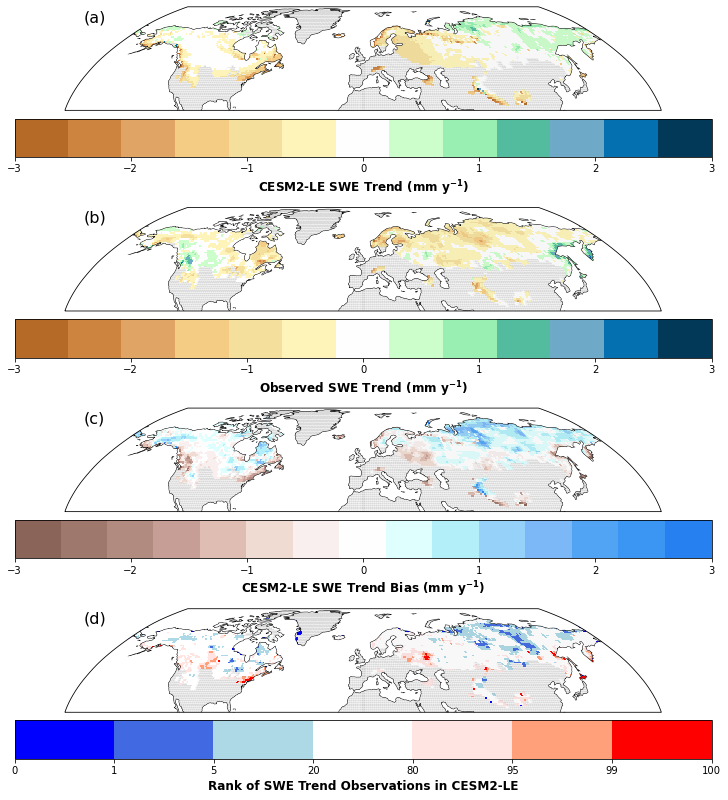

In [22]:
panel = ['(a)','(b)','(c)','(d)']
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10,11), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
i = 0
for index, ax in np.ndenumerate(axes):
    if i == 0:
        da = cesm_trend.polyfit_coefficients.isel(degree=0).mean('ens')
        cmap, units =ddd,"CESM2-LE SWE Trend (mm $\mathregular{y^{-1}}$)"
        vmax, vmin, cb = 3, -3, 1
        norm=None
    if i == 1:
        da = obs_trend.polyfit_coefficients.isel(degree=0)
        cmap, units =ddd,"Observed SWE Trend (mm $\mathregular{y^{-1}}$)"
        vmax, vmin, cb = 3, -3, 1

    if i == 2: 
        da = trend_bias
        cmap, units = ccc, "CESM2-LE SWE Trend Bias (mm $\mathregular{y^{-1}}$)"
        vmax, vmin, cb = 3, -3, 1
        
    if i == 3: 
        da = ranked
        cmap, units='PuOr', 'Rank of SWE Trend Observations in CESM2-LE'
        vmax, vmin,cb = None,None, 1
        cmap , norm = from_levels_and_colors([0, 1, 5, 20 , 80, 95, 99,100.01], 
                        ['blue','royalblue','lightblue','white', 'mistyrose','lightsalmon','red'])
        
    map_function(da, panel=panel[i], ax=ax, 
                 cmap=cmap, units= units,
                 vmax=vmax,vmin=vmin,cb=cb, norm=norm)

    i = i+1
pathOUT = '/glade/scratch/wwieder/VernalWindow/'
fileOUT =  pathOUT + 'FigS2_global_SWE_TREND.pdf' 
print(fileOUT)
plt.savefig(fileOUT) ;    


-------
------

## Read in Univ of AZ high res (4km) data
--------


Check to see if max SWE occurs in March. 

If not we should likely just read in max water year values? 

With global data we read in whole time series, regridded, then picked annual maxima.

These data are organized by water year, complicating how to select max values...

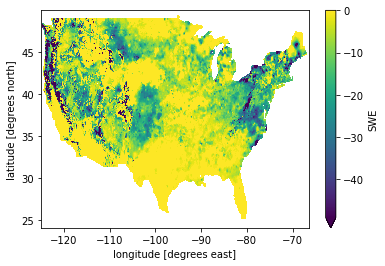

In [23]:
fileIN = pathIN + 'UA/4km_SWE_Depth_WY1990_v01.nc'
temp = xr.open_mfdataset(fileIN)
maxAnn = temp.SWE.max('time')
maxMar = temp.SWE.where(temp.time['time.month'] == 3).max('time')
maxApr = temp.SWE.where(temp.time['time.month'] == 4).max('time')
(maxMar - maxAnn).plot(robust=True);#vmax=100,vmin=-100,cmap='bwr') ; 

In [24]:
# Max SWE does not occur in march in all years / grids 
# (maxApr - maxAnn).plot(vmax=100,vmin=-100,cmap='bwr') ; 

In [25]:
fileIN

'/glade/p/cgd/tss/people/wwieder/SNOW_OBS/UA/4km_SWE_Depth_WY1990_v01.nc'

#### Reading in max annual SWE for each water year

In [26]:
%%time
fileIN =  pathIN + 'UA/4km_SWE_Depth_WY*v01.nc'

def preprocess(ds):
    '''get max March values'''
    return ds.max('time')#.where(ds.time['time.month'] == 3).max('time')

ds = xr.open_mfdataset(fileIN,preprocess=preprocess,
                       combine='nested',parallel=True,
                       concat_dim=['time']).persist()
_ = wait(ds)
ds['lon'] = ds.lon + 360
print(' -- Data read in -- ')

 -- Data read in -- 
CPU times: user 1.57 s, sys: 168 ms, total: 1.73 s
Wall time: 30.1 s


<xarray.DataArray 'lon' ()>
array(235.)
<xarray.DataArray 'lon' ()>
array(293.5)


<xarray.DataArray 'time' (time: 39)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38])
Dimensions without coordinates: time

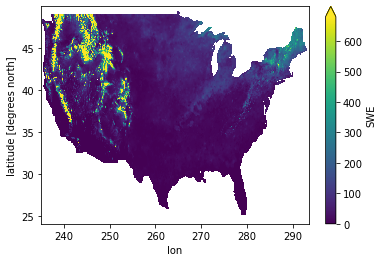

In [27]:
ds.SWE.isel(time=0).plot(robust=True) ;
minLat, maxLat = ds.lat.min(), ds.lat.max()
minLon, maxLon = ds.lon.min(), ds.lon.max()
print(minLon)
print(maxLon)
ds.time

#### Read in CESM results, 
- here from single ensemble member, just to get target grid  

/glade/campaign/cgd/cesm/CESM2-LE/timeseries/lnd/proc/tseries/month_1/H2OSNO/b.e21.BHISTcmip6.f09_g17.LE2-1301.009.clm2.h0.H2OSNO.199001-199912.nc


<xarray.DataArray 'H2OSNO' (time: 120, lat: 27, lon: 47)>
dask.array<getitem, shape=(120, 27, 47), dtype=float32, chunksize=(120, 27, 47), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 235.0 236.2 237.5 238.8 ... 288.8 290.0 291.2 292.5
  * lat      (lat) float32 24.97 25.92 26.86 27.8 ... 46.65 47.59 48.53 49.48
  * time     (time) object 1990-02-01 00:00:00 ... 2000-01-01 00:00:00
Attributes:
    long_name:     snow depth (liquid water)
    units:         mm
    cell_methods:  time: mean

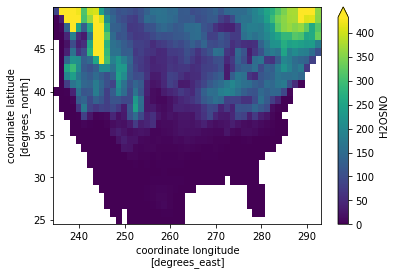

In [28]:
CESM_in = '/glade/campaign/cgd/cesm/CESM2-LE/timeseries/'+ \
            'lnd/proc/tseries/month_1/H2OSNO/'
CESM_in = CESM_in + 'b.e21.BHISTcmip6.f09_g17.LE2-1301.009.clm2.h0.H2OSNO.199001-199912.nc'

print(CESM_in)
dsCESM = xr.open_mfdataset(CESM_in)

#Mask to CONUS
dsCESM = dsCESM.sel(lat=slice(minLat,maxLat),lon=slice(minLon,maxLon))
dsCESM.H2OSNO.max('time').plot(robust=True) ;    
dsCESM.H2OSNO

#### Regrid to CESM2-LE 1&deg; resolution

In [29]:
import xesmf as xe  # to regrid observations

ds_out = xr.Dataset({'lat': (['lat'], dsCESM.lat[1:None]),
                     'lon': (['lon'], dsCESM.lon)})

# NOTE: [from xesmf], Data arrays should have (lat, lon) on the right. 
# If not, use DataArray.transpose or numpy.transpose to preprocess the data.
# Note this is also a pretty quick and dirty job, not sure how coastlines are bing handled?

Regridder = xe.Regridder(ds, ds_out, 'bilinear',periodic=False, reuse_weights=False)

In [30]:
ds_out = Regridder(ds)

/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/xesmf/frontend.py:508: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


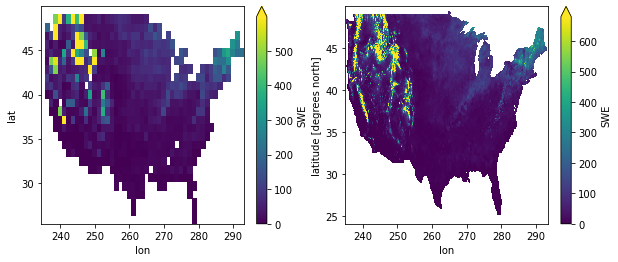

In [31]:
plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
ds_out.SWE.isel(time=0).plot(robust=True) ;
plt.subplot(1,2,2)
ds.SWE.isel(time=0).plot(robust=True) ;

#### Mask out observations as with CESM2-LE

In [32]:
LE_in = '/glade/scratch/wwieder/VernalWindow/SnowStatsSWE_ens*.nc'
LE_ds = xr.open_mfdataset(LE_in,combine='nested',parallel=True,
                                    concat_dim=['ens']).persist()
# mask out to CONUS
LE_ds = LE_ds.sel(lat=slice(minLat,maxLat),lon=slice(minLon,maxLon))

In [33]:
LE_ds
# MaxSnow is from H2OSNO = SWE

<xarray.Dataset>
Dimensions:        (ens: 40, lat: 26, lon: 47, time: 251)
Coordinates:
  * time           (time) int64 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100
  * lon            (lon) float32 235.0 236.2 237.5 238.8 ... 290.0 291.2 292.5
  * lat            (lat) float32 25.92 26.86 27.8 28.74 ... 47.59 48.53 49.48
  * ens            (ens) int64 10 11 12 13 14 15 16 17 ... 43 44 45 46 47 48 49
    year           (time) int64 dask.array<chunksize=(251,), meta=np.ndarray>
Data variables:
    MaxSnow        (ens, time, lat, lon) float32 dask.array<chunksize=(10, 251, 26, 47), meta=np.ndarray>
    MaxQrun        (ens, time, lat, lon) float64 dask.array<chunksize=(10, 251, 26, 47), meta=np.ndarray>
    TotQrun        (ens, time, lat, lon) float64 dask.array<chunksize=(10, 251, 26, 47), meta=np.ndarray>
    TotMELT        (ens, time, lat, lon) float32 dask.array<chunksize=(10, 251, 26, 47), meta=np.ndarray>
    WinMELT        (ens, time, lat, lon) float32 dask.array<chunksize=(10, 251, 26, 47), meta=np.ndarray>
    f_WinMELT      (ens, time, lat, lon) float32 dask.array<chunksize=(10, 251, 26, 47), meta=np.ndarray>
    MaxQrunDate    (ens, time, lat, lon) float64 dask.array<chunksize=(10, 251, 26, 47), meta=np.ndarray>
    CT             (ens, time, lat, lon) float64 dask.array<chunksize=(10, 251, 26, 47), meta=np.ndarray>
    FirstSnowFree  (ens, time, lat, lon) float64 dask.array<chunksize=(10, 251, 26, 47), meta=np.ndarray>
    LastSnowFree   (ens, time, lat, lon) float64 dask.array<chunksize=(10, 251, 26, 47), meta=np.ndarray>
    SnowFree       (ens, time, lat, lon) float64 dask.array<chunksize=(10, 251, 26, 47), meta=np.ndarray>

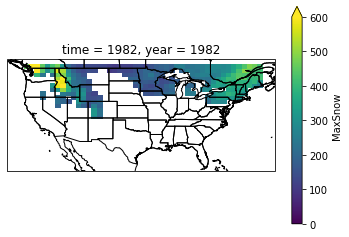

In [34]:
#subset over observational period (1982-2020)
import cartopy.feature as cfeature
temp = LE_ds.MaxSnow.sel(time=slice(1982,2020)).max(['ens'])
ax = plt.axes(projection=ccrs.PlateCarree())
temp.isel(time=0).plot.pcolormesh(ax=ax, vmin=0, vmax=600);
ax.coastlines();
ax.add_feature(cfeature.STATES, edgecolor='black', zorder=10) ;

In [35]:
# Subset obs over model domain
ds_out = ds_out.where(temp.max(['time'])>0)

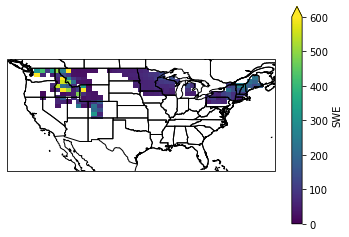

In [36]:
obs = ds_out.SWE
obs = obs.where(obs.max('time') > 10)
ax = plt.axes(projection=ccrs.PlateCarree())
obs.mean('time').plot.pcolormesh(ax=ax, vmin=0, vmax=600);
ax.coastlines();
ax.add_feature(cfeature.STATES, edgecolor='black', zorder=10) ;

(1.0, 3000.0)

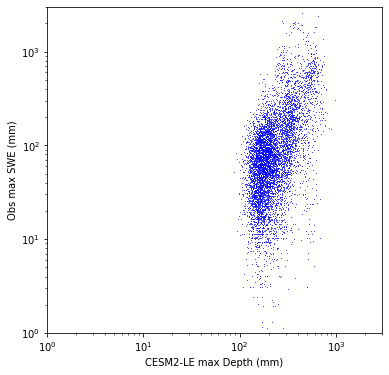

In [37]:
fig = plt.figure(figsize=[6,6])
ax = fig.add_subplot(111)
for i in range(len(temp.time)):
    ax.loglog(temp.isel(time=i), obs.isel(time=i),',',color='blue',alpha=0.7) ;

ax.set_xlabel('CESM2-LE max Depth (mm)')
ax.set_ylabel('Obs max SWE (mm)')
ax.set_xlim([1e0, 3e3])
ax.set_ylim([1e0, 3e3])

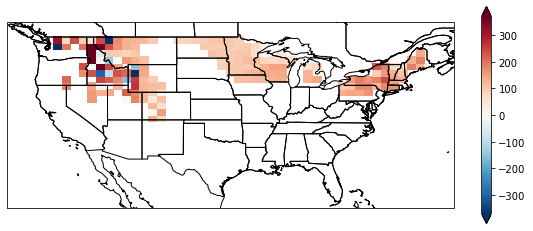

In [38]:
plt.figure(figsize=[10,4])
error = temp - obs
ax = plt.axes(projection=ccrs.PlateCarree())
error.mean('time').plot(robust=True);
ax.coastlines();
ax.add_feature(cfeature.STATES, edgecolor='black', zorder=10) ;

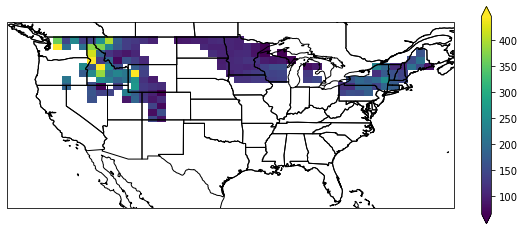

In [39]:
plt.figure(figsize=[10,4])
ax = plt.axes(projection=ccrs.PlateCarree())
RMSE = (error**2).mean('time')**0.5
RMSE.plot(robust=True)
ax.coastlines();
ax.add_feature(cfeature.STATES, edgecolor='black', zorder=10) ;

---- 
#### Look at trends

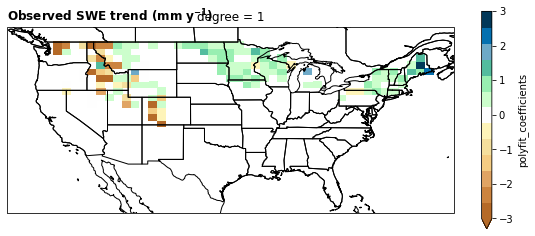

In [40]:
obs_trend = obs.polyfit('time',1,full=True)

plt.figure(figsize=[10,4])
ax = plt.axes(projection=ccrs.PlateCarree())
obs_trend.polyfit_coefficients.isel(degree=0).plot(cmap=ddd,vmax=3,vmin=-3) ;
ax.coastlines();
ax.add_feature(cfeature.STATES, edgecolor='black', zorder=10) ;
ax.set_title('Observed SWE trend (mm $\mathregular{y^{-1}}$)', loc='left', fontsize='large', fontweight='bold') ;
#obs_trend

In [41]:
cesm_SWE = LE_ds.MaxSnow.sel(time=slice(1982,2020))
cesm_trend = cesm_SWE.polyfit('time',1,full=True)
cesm_trend

<xarray.Dataset>
Dimensions:               (degree: 2, ens: 40, lat: 26, lon: 47)
Coordinates:
  * degree                (degree) int64 1 0
  * ens                   (ens) int64 10 11 12 13 14 15 16 ... 44 45 46 47 48 49
  * lat                   (lat) float64 25.92 26.86 27.8 ... 47.59 48.53 49.48
  * lon                   (lon) float64 235.0 236.2 237.5 ... 290.0 291.2 292.5
Data variables:
    time_matrix_rank      int64 2
    time_singular_values  (degree) float64 1.414 0.003977
    polyfit_coefficients  (degree, ens, lat, lon) float64 dask.array<chunksize=(2, 10, 26, 47), meta=np.ndarray>
    polyfit_residuals     (ens, lat, lon) float64 dask.array<chunksize=(10, 26, 47), meta=np.ndarray>

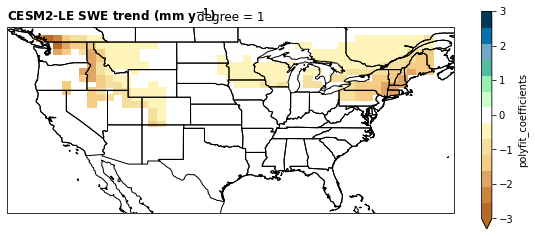

In [42]:
plt.figure(figsize=[10,4])
ax = plt.axes(projection=ccrs.PlateCarree())
cesm_trend.mean('ens').polyfit_coefficients.isel(degree=0).plot(cmap=ddd,vmax=3,vmin=-3) ;
ax.coastlines();
ax.add_feature(cfeature.STATES, edgecolor='black', zorder=10) ;
ax.set_title('CESM2-LE SWE trend (mm $\mathregular{y^{-1}}$)', loc='left', fontsize='large', fontweight='bold') ;


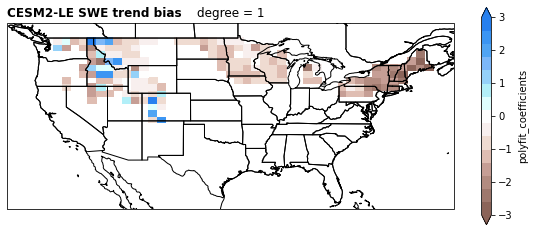

In [43]:
trend_bias = cesm_trend.mean('ens').polyfit_coefficients.isel(degree=0) - \
             obs_trend.polyfit_coefficients.isel(degree=0)

plt.figure(figsize=[10,4])
ax = plt.axes(projection=ccrs.PlateCarree())
trend_bias.plot(cmap=ccc,vmax=3,vmin=-3) ;
ax.coastlines();
ax.add_feature(cfeature.STATES, edgecolor='black', zorder=10) ;
ax.set_title('CESM2-LE SWE trend bias', loc='left', fontsize='large', fontweight='bold') ;

# mask out all but common grids
cesm_trend = cesm_trend.where(trend_bias>-100)
obs_trend = obs_trend.where(trend_bias>-100)

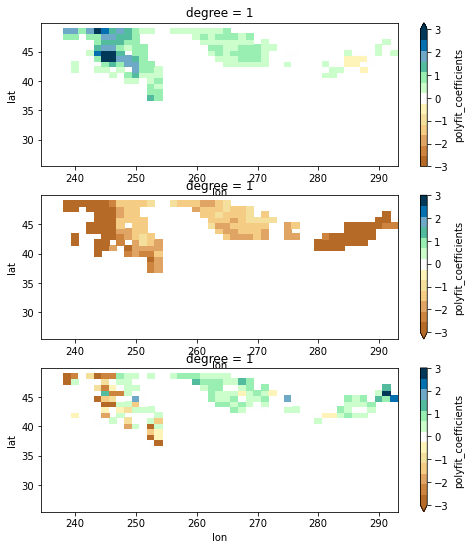

In [44]:
cesm_max = cesm_trend.max('ens').polyfit_coefficients.isel(degree=0)
cesm_min = cesm_trend.min('ens').polyfit_coefficients.isel(degree=0)
plt.figure(figsize=[8,9])
plt.subplot(3,1,1) # max values
cesm_max.plot(cmap=ddd,vmax=3,vmin=-3)
plt.subplot(3,1,2) # Min values
cesm_min.plot(cmap=ddd,vmax=3,vmin=-3)
plt.subplot(3,1,3) # Obs Trends
obs_trend.polyfit_coefficients.isel(degree=0).plot(cmap=ddd,vmax=3,vmin=-3)  ;

#### Add obs_trend to cesm_trend as ens 41

array(2.43902439)

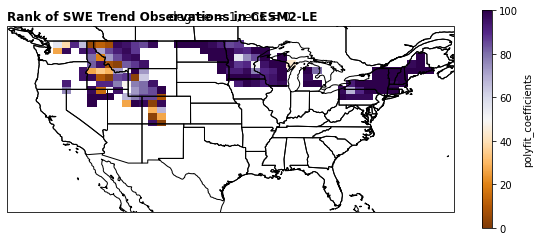

In [45]:
combined = xr.combine_nested([cesm_trend, obs_trend.expand_dims("ens")], 'ens')
ranked = combined.polyfit_coefficients.isel(degree=0).compute().rank('ens').isel(ens=40)
ranked = ranked / 41 * 100
ranked = ranked.where(ranked>(1/41), 0) #/41 * 100
ranked = ranked.where(ranked<100, 100) #/41 * 100
ranked = ranked.where(trend_bias>-100)

plt.figure(figsize=[10,4])
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title('Rank of SWE Trend Observations in CESM2-LE', loc='left', fontsize='large', fontweight='bold') ;
ranked.plot(vmax=100,vmin=0,cmap='PuOr')
ax.coastlines();
ax.add_feature(cfeature.STATES, edgecolor='black', zorder=10) ;

ranked.min().values

In [46]:
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import copy
from matplotlib.colors import from_levels_and_colors

# Generate a function for making panel plots of maps
def map_function(da, cb=0, cmap='viridis', panel=None,  ax=None, 
                 title=None, vmax=None, vmin=None, units=None, norm=None):
    '''a function to make one subplot'''
    wrap_data, wrap_lon = add_cyclic_point(da.values, coord=da.lon)

    if ax is None: ax = plt.gca()

    cmap = copy.copy(plt.get_cmap(cmap))
    cmap.set_bad( "gray", alpha=0.05 )
    cmap.set_under( "white", alpha=1 )

    im = ax.pcolormesh(wrap_lon,da.lat,wrap_data,
                       transform=ccrs.PlateCarree(),
                       vmax=vmax,vmin=vmin,cmap=cmap,
                       norm=norm)

    ax.set_title(title,loc='left', fontsize='large', fontweight='bold')
    ax.coastlines()
    ax.set_extent([240,293.5,25,50], crs=ccrs.PlateCarree())
    ax.annotate(panel, xy=(0.05, 0.90), xycoords=ax.transAxes,
                ha='center', va='center',fontsize=16)    
    ocean = ax.add_feature(
        cfeature.NaturalEarthFeature('physical','ocean','110m', facecolor='white'))
    borders = ax.add_feature(cfeature.STATES, edgecolor='black', zorder=10)
    # allows for different colorbars on each plot
    if cb == 1:
        cbar = fig.colorbar(im, ax=ax,pad=0.02, fraction = 0.05, orientation='horizontal')
        cbar.set_label(units,size=12,fontweight='bold')
    if cb == 2:
        cbar = fig.colorbar(im, ax=ax,pad=0.02, fraction = 0.05, orientation='vertical')    
        cbar.set_label(units,size=12)#,weight='bold')


/glade/scratch/wwieder/VernalWindow/FigS3_CONUS_SWE_TREND.pdf


/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.


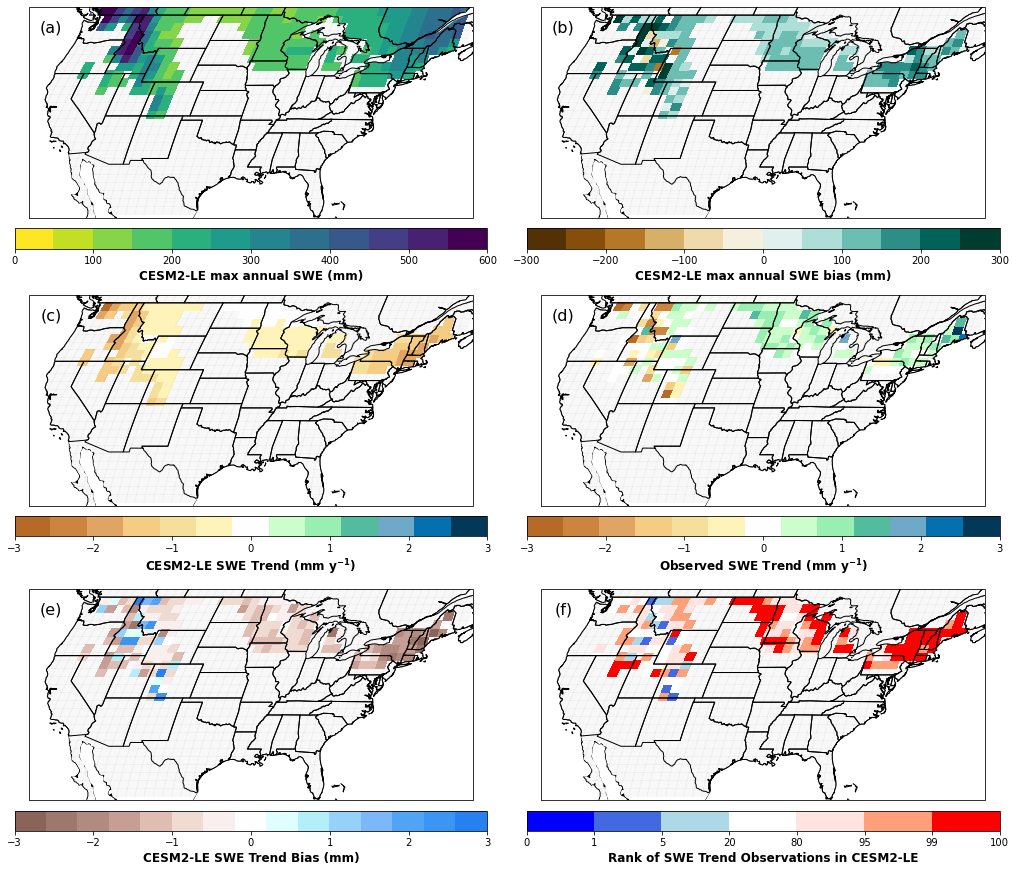

In [47]:
panel = ['(a)','(b)','(c)','(d)','(e)','(f)']
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14,12), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
i = 0
for index, ax in np.ndenumerate(axes):
    if i == 0:
        da = temp.mean('time')
        cmap, units =cm.get_cmap('viridis_r', 12) ,"CESM2-LE max annual SWE (mm)"
        vmax, vmin, cb = 600, 0, 1
        norm=None
    if i == 1:
        da = error.mean('time')
        cmap, units = cm.get_cmap('BrBG', 12),"CESM2-LE max annual SWE bias (mm)"
        vmax, vmin, cb = -300,300, 1
        norm=None
    if i == 2:
        da = cesm_trend.polyfit_coefficients.isel(degree=0).mean('ens')
        cmap, units =ddd,"CESM2-LE SWE Trend (mm $\mathregular{y^{-1}}$)"
        vmax, vmin, cb = 3, -3, 1
        norm=None
    if i == 3:
        da = obs_trend.polyfit_coefficients.isel(degree=0)
        cmap, units =ddd,"Observed SWE Trend (mm $\mathregular{y^{-1}}$)"
        vmax, vmin, cb = 3, -3, 1

    if i == 4: 
        da = trend_bias
        cmap, units = ccc, "CESM2-LE SWE Trend Bias (mm)"
        vmax, vmin, cb = 3, -3, 1
        
    if i == 5: 
        da = ranked
        cmap, units='PuOr', 'Rank of SWE Trend Observations in CESM2-LE'
        vmax, vmin,cb = None,None, 1
        cmap , norm = from_levels_and_colors([0, 1, 5, 20 , 80, 95, 99,100.01], 
                        ['blue','royalblue','lightblue','white', 'mistyrose','lightsalmon','red'])
        
    map_function(da, panel=panel[i], ax=ax, 
                 cmap=cmap, units= units,
                 vmax=vmax,vmin=vmin,cb=cb, norm=norm)

    i = i+1
    
pathOUT = '/glade/scratch/wwieder/VernalWindow/'
fileOUT =  pathOUT + 'FigS3_CONUS_SWE_TREND.pdf' 
print(fileOUT)
plt.savefig(fileOUT) ;    

array(100.)

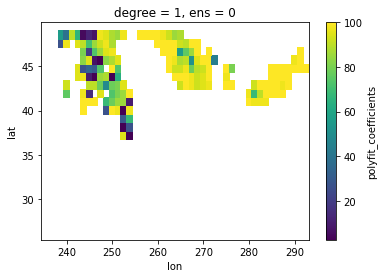

In [48]:
da.plot() ;
da.max().values

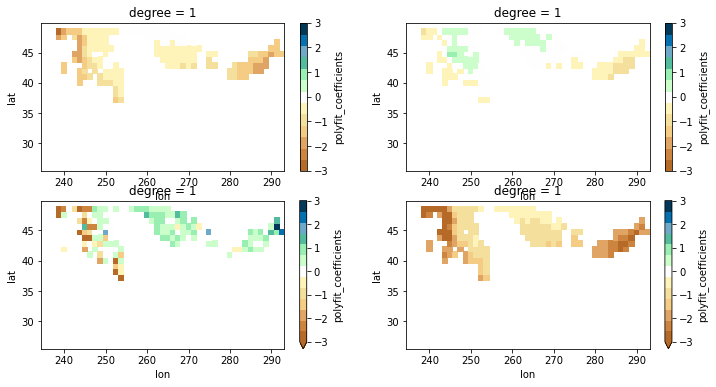

In [49]:
meanCESM = cesm_trend.polyfit_coefficients.isel(degree=0).mean('ens')
stdCESM = cesm_trend.polyfit_coefficients.isel(degree=0).std('ens')
rangeCESM1 = meanCESM + stdCESM
rangeCESM2 = meanCESM - stdCESM
plt.figure(figsize=[12,6])
plt.subplot(2,2,1)
meanCESM.plot(cmap=ddd,vmax=3,vmin=-3)
plt.subplot(2,2,2)
rangeCESM1.plot(cmap=ddd,vmax=3,vmin=-3)
plt.subplot(2,2,4)
rangeCESM2.plot(cmap=ddd,vmax=3,vmin=-3)
plt.subplot(2,2,3)
obs_trend.polyfit_coefficients.isel(degree=0).plot(cmap=ddd,vmax=3,vmin=-3)  ;


--------
-----
### Repeat with ILAMB data
------


In [50]:
ILAMB_path = '/glade/p/cesm/lmwg_dev/oleson/ILAMB/ILAMB_all/DATA/'
# Check with Nate or Dave to see if other options are better here?

ILAMB_tas = xr.open_mfdataset(ILAMB_path + 'tas/CRU/tas_0.5x0.5.nc')
ILAMB_pr  = xr.open_mfdataset(ILAMB_path + 'pr/GPCP2/pr_0.5x0.5.nc')
ILAMB_swe = xr.open_mfdataset(ILAMB_path + 'swe/CanSISE/*nc')
ILAMB_gpp = xr.open_mfdataset(ILAMB_path + 'gpp/FLUXNET-MTE/*nc')
ILAMB_run  = xr.open_mfdataset(ILAMB_path + 'runoff/LORA/*nc')
ILAMB_et  = xr.open_mfdataset(ILAMB_path + 'et/GLEAMv3.3a/*nc')

# open global dataset again
dsCESM = xr.open_mfdataset(CESM_in)

**Other data products include:**
- Temperature = CRU [also available: CRU4.02  FLUXNET  FLUXNET2015]
- Precip = GPCP2 [also available: CMAP  CMAPv1904  FLUXNET  FLUXNET2015  GPCC  GPCCv2018  GPCPv2.3]
- SWE = CanSISE 
- ET = GLEAMv3.3a [also available: DOLCE  GLEAM  MOD16A2  MODIS ]
- GPP = FLUXNET-MTE [also FLUXCOM  FLUXNET  FLUXNET2015  FLUXNET-MTE  GBAF]
- Runoff = LORA [also Dai]

#### Quick plot of data

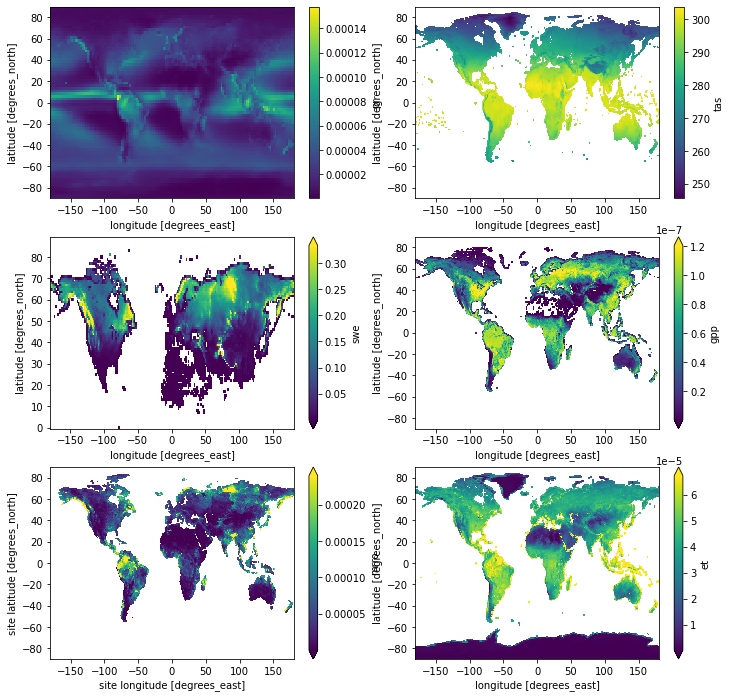

In [51]:
ILAMB_swe = ILAMB_swe.where(ILAMB_swe.swe<=1e36)

plt.figure(figsize=[12,12])
plt.subplot(3,2,1)
ILAMB_pr.pr.mean('time').plot()  
plt.subplot(3,2,2)
ILAMB_tas.tas.mean('time').plot()  
plt.subplot(3,2,3)
ILAMB_swe.swe.max('time').plot(robust=True) 
plt.subplot(3,2,4)
ILAMB_gpp.gpp.max('time').plot(robust=True) 
plt.subplot(3,2,5)
ILAMB_run.mrro.max('time').plot(robust=True)
plt.subplot(3,2,6)
ILAMB_et.et.max('time').plot(robust=True) ;

#### make target grid

In [52]:
tas_out = xr.Dataset({'lat': (['lat'], dsCESM.lat),
                     'lon': (['lon'], dsCESM.lon)})

pr_out  = tas_out
lat2 = dsCESM.lat.isel(lat=slice(96,None))
swe_out = xr.Dataset({'lat': (['lat'], lat2),
                     'lon': (['lon'], dsCESM.lon)})
gpp_out = tas_out
run_out = tas_out
et_out  = tas_out

# NOTE: [from xesmf], Data arrays should have (lat, lon) on the right. 
# If not, use DataArray.transpose or numpy.transpose to preprocess the data.
# Note this is also a pretty quick and dirty job, not sure how coastlines are bing handled?

tas_Regridder = xe.Regridder(ILAMB_tas, tas_out, 'bilinear',periodic=True, reuse_weights=False)
pr_Regridder  = xe.Regridder(ILAMB_pr,  pr_out,  'bilinear',periodic=True, reuse_weights=False)
swe_Regridder = xe.Regridder(ILAMB_swe, swe_out, 'bilinear',periodic=True, reuse_weights=False)
gpp_Regridder = xe.Regridder(ILAMB_gpp, gpp_out, 'bilinear',periodic=True, reuse_weights=False)
run_Regridder = xe.Regridder(ILAMB_run, run_out, 'bilinear',periodic=True, reuse_weights=False)
et_Regridder  = xe.Regridder(ILAMB_et , et_out,  'bilinear',periodic=True, reuse_weights=False)


In [53]:
tas_out = tas_Regridder(ILAMB_tas)
pr_out  = pr_Regridder(ILAMB_pr)
swe_out = swe_Regridder(ILAMB_swe)
gpp_out = gpp_Regridder(ILAMB_gpp)
run_out = run_Regridder(ILAMB_run)
et_out  = et_Regridder(ILAMB_et)


/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/xesmf/frontend.py:508: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/xesmf/frontend.py:508: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/xesmf/frontend.py:508: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/xesmf/frontend.py:508: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. I

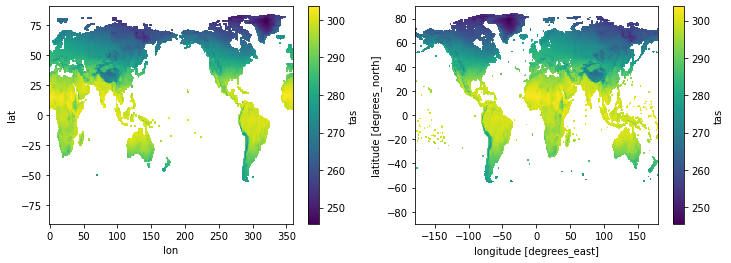

In [54]:
plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
tas_out.tas.mean('time').plot()  
plt.subplot(1,2,2)
ILAMB_tas.tas.mean('time').plot()  ;

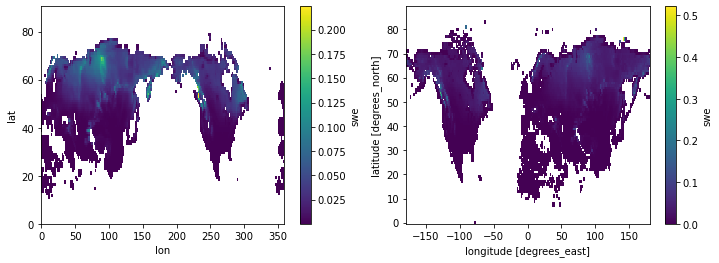

In [55]:
plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
swe_out.swe.mean('time').plot()  
plt.subplot(1,2,2)
ILAMB_swe.swe.mean('time').plot()  ;

In [56]:
tas_out.tas.attrs = ILAMB_tas.tas.attrs
pr_out.pr.attrs = ILAMB_pr.pr.attrs
swe_out.swe.attrs = ILAMB_swe.swe.attrs
gpp_out.gpp.attrs = ILAMB_gpp.gpp.attrs
et_out.et.attrs = ILAMB_et.et.attrs
run_out.mrro.attrs = ILAMB_run.mrro.attrs


In [57]:
swe_out.swe
tas_out.tas

<xarray.DataArray 'tas' (time: 408, lat: 192, lon: 288)>
dask.array<transpose, shape=(408, 192, 288), dtype=float64, chunksize=(408, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1979-01-16 12:00:00 ... 2012-12-16 12:00:00
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
Attributes:
    units:      K
    long_name:  surface air temperature

#### Write out results to disk

In [58]:
outDir = '/glade/scratch/wwieder/VernalWindow/'

tas_out.to_netcdf(outDir+'tas.nc')
pr_out.to_netcdf(outDir+'pr.nc')
swe_out.swe.to_netcdf(outDir+'swe.nc')
gpp_out.to_netcdf(outDir+'gpp.nc')
run_out.to_netcdf(outDir+'run.nc')
et_out.to_netcdf(outDir+'et.nc')
print('wrote files to '+outDir)

wrote files to /glade/scratch/wwieder/VernalWindow/


----------
### Again look for trends in T and P, focus on CONUS?

In [59]:
# calculate mean annual JFM trends
tas_win = tas_out.tas.where(tas_out.time['time.month']<=3)
tas_win = tas_win.groupby(tas_win.time['time.year']).mean('time')
pr_win = pr_out.pr.where(pr_out.time['time.month']<=3)
pr_win = pr_win.groupby(pr_win.time['time.year']).mean('time')

pr_win

<xarray.DataArray 'pr' (year: 34, lat: 192, lon: 288)>
dask.array<stack, shape=(34, 192, 288), dtype=float64, chunksize=(1, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * year     (year) int64 1979 1980 1981 1982 1983 ... 2008 2009 2010 2011 2012

#### Mask out observations as with CESM2-LE

In [60]:
# mask out observations to LE output

minLat,maxLat
LE_ds = LE_ds.sel(lat=slice(minLat,maxLat))
minY, maxY = MudSnow_out.time.min(), MudSnow_out.time.max()


<xarray.Dataset>
Dimensions:               (degree: 2, lat: 26, lon: 47)
Coordinates:
  * degree                (degree) int64 1 0
  * lat                   (lat) float64 25.92 26.86 27.8 ... 47.59 48.53 49.48
  * lon                   (lon) float64 235.0 236.2 237.5 ... 290.0 291.2 292.5
Data variables:
    polyfit_coefficients  (degree, lat, lon) float64 dask.array<chunksize=(2, 26, 47), meta=np.ndarray>

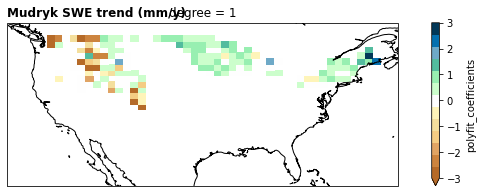

In [61]:
obs_trend = obs.polyfit('time',1)

plt.figure(figsize=[12,3])
ax = plt.axes(projection=ccrs.PlateCarree())
obs_trend.polyfit_coefficients.isel(degree=0).plot(cmap=ddd,vmax=3,vmin=-3) ;
ax.coastlines();
ax.set_title('Mudryk SWE trend (mm/y)', loc='left', fontsize='large', fontweight='bold') ;
obs_trend

### plot SWE Biases from two products

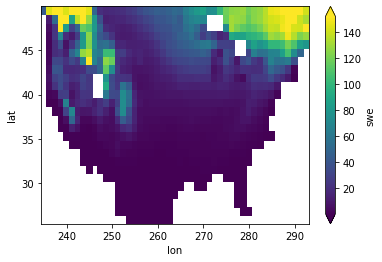

In [62]:
#subset over domain and convert from m to mm
minLat = temp.lat.min()
canSISE = swe_out.swe.sel(lat=slice(minLat,maxLat),lon=slice(minLon,maxLon)).groupby('time.year').max('time')*1e3
canSISE.mean('year').plot(robust=True);

#temp = LE_ds.MaxSnow.sel(time=slice(1982,2020)).max(['ens'])
#ax = plt.axes(projection=ccrs.PlateCarree())
#temp.isel(time=0).plot.pcolormesh(ax=ax, vmin=0, vmax=600);
#ax.coastlines();
#ax.add_feature(cfeature.STATES, edgecolor='black', zorder=10) ;



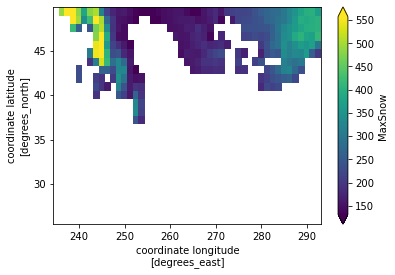

In [63]:
temp.mean('time').plot(robust=True) ; 

''

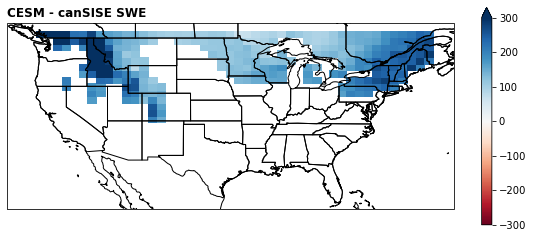

In [64]:
plt.figure(figsize=[10,4])
canError = temp.mean('time') - canSISE.mean('year')
ax = plt.axes(projection=ccrs.PlateCarree())
canError.plot(vmax=300,vmin=-300,cmap='RdBu');
ax.coastlines();
ax.add_feature(cfeature.STATES, edgecolor='black', zorder=10) 
ax.set_title('CESM - canSISE SWE', loc='left', fontsize='large', fontweight='bold') 
;

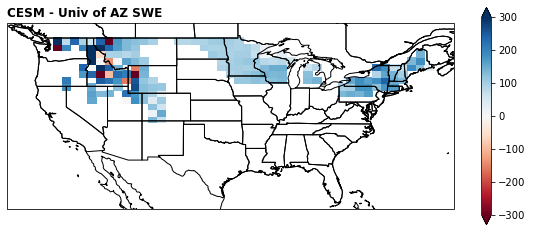

In [65]:
plt.figure(figsize=[10,4])
azError = temp.mean('time') - obs.mean('time')
ax = plt.axes(projection=ccrs.PlateCarree())
azError.plot(vmax=300,vmin=-300,cmap='RdBu');
ax.coastlines();
ax.add_feature(cfeature.STATES, edgecolor='black', zorder=10) 
ax.set_title('CESM - Univ of AZ SWE', loc='left', fontsize='large', fontweight='bold') ;

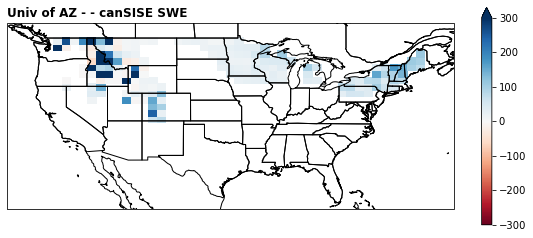

In [66]:
plt.figure(figsize=[10,4])
obsError = obs.mean('time') - canSISE.mean('year')
ax = plt.axes(projection=ccrs.PlateCarree())
obsError.plot(vmax=300,vmin=-300,cmap='RdBu');
ax.coastlines();
ax.add_feature(cfeature.STATES, edgecolor='black', zorder=10) 
ax.set_title('Univ of AZ - - canSISE SWE', loc='left', fontsize='large', fontweight='bold') ;

-----
### End of notebook 

In [67]:
# https://github.com/rasbt/watermark
%load_ext watermark
%watermark --updated --date --iversions --gitrepo --gitbranch --githash --python

Last updated: 2022-01-28

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 7.21.0

Git hash: cb4ff720b070ab95688828e7c5f322045dd3a4ea

Git repo: https://github.com/wwieder/CESM2-LE_SnowWater.git

Git branch: main

matplotlib: 3.3.4
pandas    : 1.2.3
numpy     : 1.20.1
cartopy   : 0.18.0
xarray    : 0.17.0
scipy     : 1.6.0
cftime    : 1.4.1
xesmf     : 0.5.3
dask      : 2021.6.2

